In [1]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten, GRU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [2]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [3]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("../dataset/cleaned_NEM.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

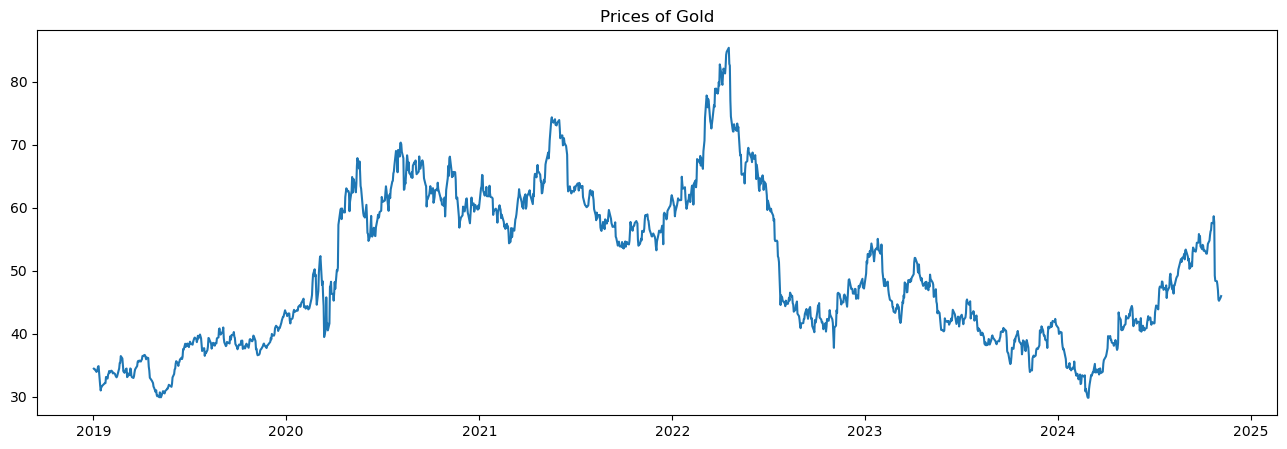

In [4]:
# Format column Date
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Close'])
df1.drop('Date', axis=1, inplace=True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16, 5))
plt.plot(df1['Close'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [5]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [6]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [7]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [8]:
# Build the model
model = Sequential()

# Add a GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another GRU layer with 50 units and return_sequences set to True
model.add(GRU(50, return_sequences=True))

# Add a final GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the model with the correct '.keras' extension
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the best model during training
best_model = ModelCheckpoint(
    filepath=save_model,
    monitor='loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# Train the model using the 'fit' method
model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=50,
    verbose=2,
    callbacks=[best_model]
)

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.14993, saving model to save_model_7_2_1.keras
21/21 - 5s - 226ms/step - loss: 0.1499
Epoch 2/80

Epoch 2: loss improved from 0.14993 to 0.03481, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0348
Epoch 3/80

Epoch 3: loss improved from 0.03481 to 0.02754, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0275
Epoch 4/80

Epoch 4: loss improved from 0.02754 to 0.02501, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0250
Epoch 5/80

Epoch 5: loss did not improve from 0.02501
21/21 - 0s - 5ms/step - loss: 0.0259
Epoch 6/80

Epoch 6: loss did not improve from 0.02501
21/21 - 0s - 5ms/step - loss: 0.0258
Epoch 7/80

Epoch 7: loss improved from 0.02501 to 0.02456, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0246
Epoch 8/80

Epoch 8: loss improved from 0.02456 to 0.02449, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0245
Epoch 9/80

E

In [9]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


In [10]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [11]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [12]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)
     

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [13]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [14]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29041963815689087], [0.29045456647872925], [0.2904333770275116], [0.29049572348594666], [0.2905844449996948], [0.2906675338745117], [0.29074835777282715], [0.29082614183425903], [0.29090186953544617], [0.2909756302833557], [0.29104751348495483], [0.2911175787448883], [0.29118579626083374], [0.2912522554397583], [0.29131704568862915], [0.2913801074028015], [0.29144158959388733], [0.2915014624595642], [0.29155975580215454], [0.2916165590286255], [0.29167190194129944], [0.29172584414482117], [0.2917783856391907], [0.29182952642440796], [0.2918793559074402], [0.29192790389060974], [0.2919752597808838], [0.29202139377593994], [0.2920663356781006], [0.2921101152896881]]


In [15]:
# Convert the 'Date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string '%Y-%m-%d'
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 30 days
datelist_future = pd.date_range(datelist_train[-1] + dt.timedelta(days=1), periods=30, freq='1d').tolist()

In [16]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[45.995715  ]
 [45.99765561]
 [45.99647833]
 [45.9999423 ]
 [46.00487167]
 [46.00948808]
 [46.01397866]
 [46.01830034]
 [46.02250777]
 [46.02660592]
 [46.03059975]
 [46.03449257]
 [46.03828274]
 [46.04197521]
 [46.04557496]
 [46.04907867]
 [46.05249462]
 [46.05582115]
 [46.05905993]
 [46.06221592]
 [46.06529077]
 [46.0682878 ]
 [46.071207  ]
 [46.07404839]
 [46.07681691]
 [46.07951424]
 [46.08214533]
 [46.08470854]
 [46.08720551]
 [46.0896379 ]]


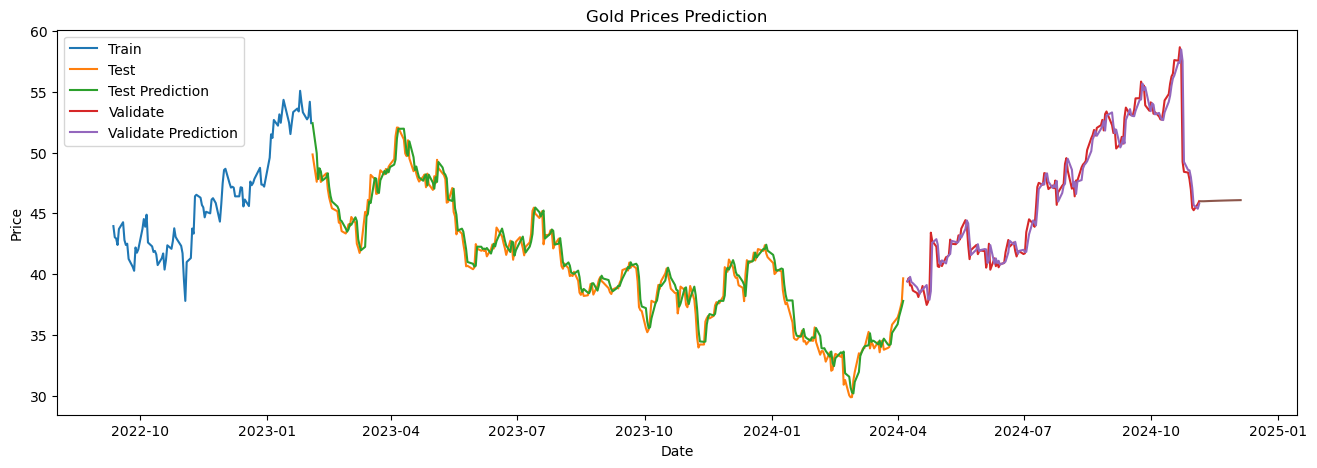

In [17]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [18]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.6811685757294654
MAPE:  1.6985677098967662
RMSE:  0.8929177638490515

** Validate **
MAE:  0.7107580029386614
MAPE:  1.5230649522620254
RMSE:  1.1261998474718777


# Split dataset (6-3-1)

---



In [19]:
# Split the data
train_size = int(0.6 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [20]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [21]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [22]:
# Set the filename to use for saving the model with the correct .keras extension
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80



Epoch 1: loss improved from inf to 0.01683, saving model to save_model_6_3_1.keras
18/18 - 0s - 8ms/step - loss: 0.0168
Epoch 2/80

Epoch 2: loss did not improve from 0.01683
18/18 - 0s - 6ms/step - loss: 0.0168
Epoch 3/80

Epoch 3: loss improved from 0.01683 to 0.01609, saving model to save_model_6_3_1.keras
18/18 - 0s - 6ms/step - loss: 0.0161
Epoch 4/80

Epoch 4: loss did not improve from 0.01609
18/18 - 0s - 5ms/step - loss: 0.0162
Epoch 5/80

Epoch 5: loss did not improve from 0.01609
18/18 - 0s - 5ms/step - loss: 0.0170
Epoch 6/80

Epoch 6: loss did not improve from 0.01609
18/18 - 0s - 5ms/step - loss: 0.0169
Epoch 7/80

Epoch 7: loss improved from 0.01609 to 0.01602, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0160
Epoch 8/80

Epoch 8: loss did not improve from 0.01602
18/18 - 0s - 7ms/step - loss: 0.0163
Epoch 9/80

Epoch 9: loss did not improve from 0.01602
18/18 - 0s - 5ms/step - loss: 0.0162
Epoch 10/80

Epoch 10: loss did not improve from 0.0160

In [23]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [24]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [25]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [26]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [27]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [28]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29405224323272705], [0.29695841670036316], [0.29980209469795227], [0.3027379810810089], [0.3056752383708954], [0.3085886538028717], [0.3114667534828186], [0.3143106698989868], [0.3171232044696808], [0.31990504264831543], [0.32265615463256836], [0.3253766596317291], [0.32806646823883057], [0.33072561025619507], [0.3333541750907898], [0.3359522819519043], [0.3385199010372162], [0.3410571813583374], [0.3435641825199127], [0.3460410535335541], [0.348487913608551], [0.35090479254722595], [0.35329189896583557], [0.35564932227134705], [0.3579771816730499], [0.36027565598487854], [0.36254486441612244], [0.3647848963737488], [0.3669959306716919], [0.36917823553085327]]


In [29]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.19754253]
 [46.35900952]
 [46.51700426]
 [46.6801221 ]
 [46.84331611]
 [47.00518546]
 [47.16509267]
 [47.32310066]
 [47.47936508]
 [47.633924  ]
 [47.78677577]
 [47.93792703]
 [48.08737278]
 [48.23511471]
 [48.38115776]
 [48.52550858]
 [48.66816549]
 [48.80913677]
 [48.94842575]
 [49.0860407 ]
 [49.22198824]
 [49.35627003]
 [49.48889765]
 [49.61987609]
 [49.74921195]
 [49.87691518]
 [50.00299239]
 [50.12744856]
 [50.25029362]
 [50.37154248]]


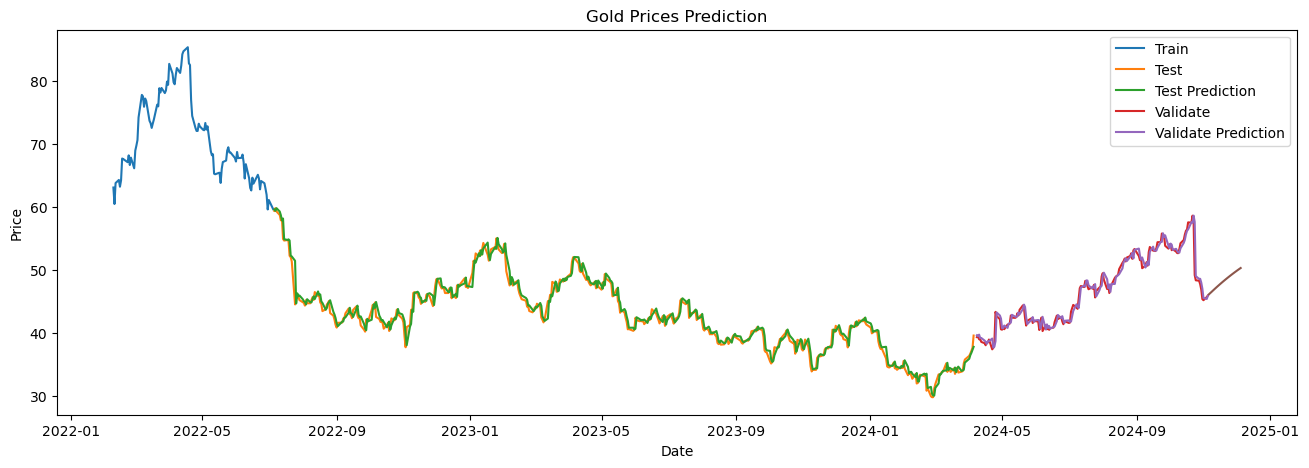

In [30]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [31]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.7264566876204538
MAPE:  1.7179906070110211
RMSE:  0.9893313426088823

** Validate **
MAE:  0.7035835627112146
MAPE:  1.5152896873813058
RMSE:  1.1231972024060268


# Split dataset (5-3-2)

---



In [32]:
# Split the data
train_size = int(0.5 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [33]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [34]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [35]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.18960, saving model to save_model_5_3_2.keras
15/15 - 4s - 252ms/step - loss: 0.1896
Epoch 2/80

Epoch 2: loss improved from 0.18960 to 0.07971, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0797
Epoch 3/80

Epoch 3: loss improved from 0.07971 to 0.03252, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0325
Epoch 4/80

Epoch 4: loss improved from 0.03252 to 0.02415, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0241
Epoch 5/80

Epoch 5: loss improved from 0.02415 to 0.02373, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0237
Epoch 6/80

Epoch 6: loss improved from 0.02373 to 0.02340, saving model to save_model_5_3_2.keras
15/15 - 0s - 7ms/step - loss: 0.0234
Epoch 7/80

Epoch 7: loss did not improve from 0.02340
15/15 - 0s - 6ms/step - loss: 0.0242
Epoch 8/80

Epoch 8: loss did not improve from 0.02340
15/15 - 0s - 7ms/step - loss: 0.0250
Epoch 9/80

E

In [36]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_5_3_2.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [37]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [38]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [39]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [40]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [41]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29235580563545227], [0.29402902722358704], [0.2957119345664978], [0.29752957820892334], [0.2993711531162262], [0.30120834708213806], [0.3030417263507843], [0.3048725128173828], [0.30670297145843506], [0.3085330128669739], [0.3103623688220978], [0.3121910095214844], [0.31401878595352173], [0.3158455789089203], [0.3176713287830353], [0.3194959759712219], [0.32131943106651306], [0.32314157485961914], [0.3249623477458954], [0.32678160071372986], [0.3285992741584778], [0.3304153084754944], [0.3322296142578125], [0.3340422511100769], [0.33585286140441895], [0.33766141533851624], [0.33946800231933594], [0.3412724435329437], [0.3430745601654053], [0.34487438201904297]]


In [42]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.10328846]
 [46.19625265]
 [46.28975497]
 [46.39074325]
 [46.49306115]
 [46.59513564]
 [46.69699819]
 [46.79871668]
 [46.90041696]
 [47.00209405]
 [47.10373306]
 [47.20533234]
 [47.30688359]
 [47.4083802 ]
 [47.50981886]
 [47.61119626]
 [47.71250742]
 [47.81374572]
 [47.91490786]
 [48.01598555]
 [48.11697548]
 [48.21787434]
 [48.31867717]
 [48.41938727]
 [48.51998477]
 [48.62046802]
 [48.72084199]
 [48.82109674]
 [48.92122234]
 [49.02122043]]


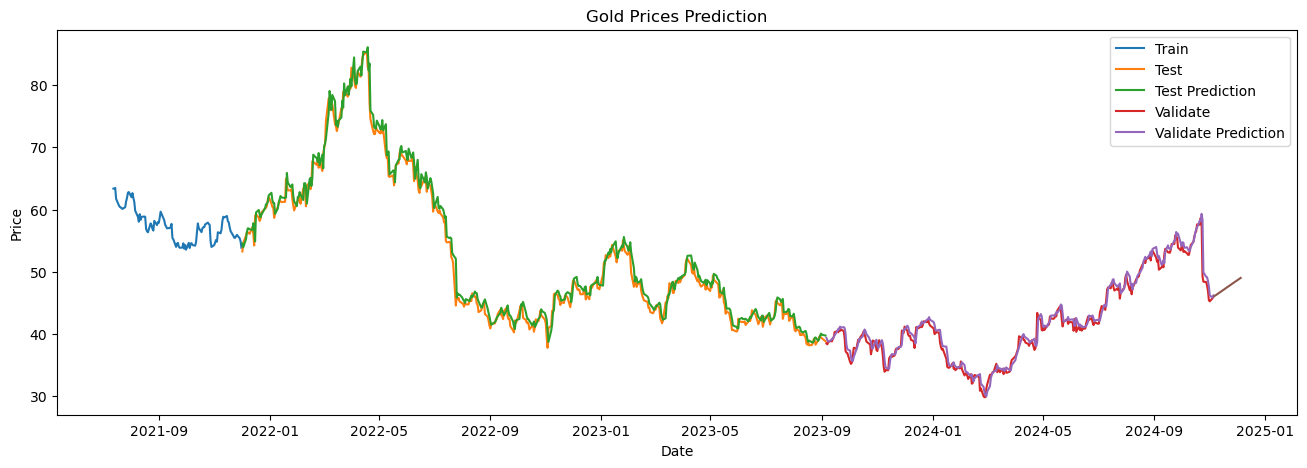

In [43]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [88]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.9088968118443079
MAPE:  1.7045286702040214
RMSE:  1.278066588340565

** Validate **
MAE:  0.6956806441249834
MAPE:  1.6919809178436531
RMSE:  1.0124372731543068


# Evaluating model

---

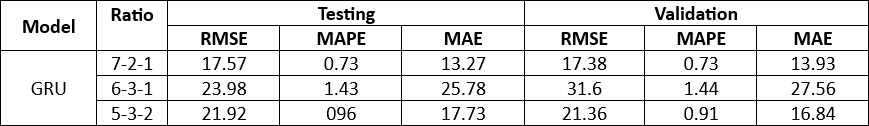
